In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import datetime as dt

In [4]:
df = pd.read_csv('sales.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

In [5]:
# Cek apakah 'date' sudah menjadi index atau masih kolom
if 'date' in df.columns:
    df = df.set_index('date').resample('D').sum().fillna(0)
elif df.index.name == 'date' or isinstance(df.index, pd.DatetimeIndex):
    # Jika sudah menjadi index, langsung resample
    df = df.resample('D').sum().fillna(0)
else:
    # Jika tidak ada kolom 'date', cari kolom yang mirip
    date_cols = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]
    if date_cols:
        df = df.set_index(date_cols[0]).resample('D').sum().fillna(0)
    else:
        print("Peringatan: Tidak menemukan kolom 'date'. Kolom yang tersedia:", df.columns.tolist())

# Cek kolom yang tersedia setelah resample
print("Kolom yang tersedia:", df.columns.tolist())
print("\n5 baris pertama:")
print(df.head())

Kolom yang tersedia: ['Unnamed: 0', 'item_id', 'quantity', 'price_base', 'sum_total', 'store_id']

5 baris pertama:
              Unnamed: 0                                            item_id  \
date                                                                          
2022-08-28   91233018798  f425b08120910a627d488d5fe7901b87566ad17432476e...   
2022-08-29  100104800770  5caba973144eb3b0fbcbfe49d31758b2c8ce7dd52610f7...   
2022-08-30  101743760349  7ea944737ef9149200c088c599db11cc23ba72c2ef8597...   
2022-08-31  102251851434  b4cdaf6cc2d00070437f5c2f150f72d6d314ddb9fd9fee...   
2022-09-01  106832763639  e24c2e422f242fe1b5aba4b977764bde8d42d76e656a90...   

             quantity  price_base   sum_total  store_id  
date                                                     
2022-08-28  35616.579  1234528.28  3900982.29      9851  
2022-08-29  41935.293  1302648.10  4563923.94     11060  
2022-08-30  40996.841  1319806.84  4532956.77     11296  
2022-08-31  43387.136  1396279.12  51490

In [6]:
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]


In [7]:
# Buat copy untuk menghindari SettingWithCopyWarning
train = train.copy()
test = test.copy()

train['t'] = np.arange(len(train))
test['t'] = np.arange(len(train), len(train) + len(test))

# Gunakan kolom 'sum_total' untuk prediksi (atau kolom lain yang relevan)
target_col = 'sum_total'  # Bisa diganti ke 'quantity' atau kolom lain

# Pastikan kolom ada, jika tidak gunakan kolom numerik pertama yang relevan
if target_col not in train.columns:
    # Pilih kolom numerik yang relevan (hindari 'Unnamed: 0', 'item_id', 'store_id')
    numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
    # Prioritaskan kolom yang relevan untuk prediksi penjualan
    preferred_cols = ['sum_total', 'quantity', 'price_base']
    target_col = None
    for col in preferred_cols:
        if col in numeric_cols:
            target_col = col
            break
    # Jika tidak ada, gunakan kolom numerik pertama yang bukan 'Unnamed: 0'
    if target_col is None:
        numeric_cols = [col for col in numeric_cols if col != 'Unnamed: 0']
        target_col = numeric_cols[0] if numeric_cols else train.columns[0]
    print(f"Kolom 'sum_total' tidak ditemukan. Menggunakan '{target_col}' sebagai gantinya.")
else:
    print(f"Menggunakan kolom '{target_col}' sebagai target untuk Linear Regression")

lr = LinearRegression()
lr.fit(train[['t']], train[target_col])

test['lr_pred'] = lr.predict(test[['t']])

Menggunakan kolom 'sum_total' sebagai target untuk Linear Regression


In [8]:
# Gunakan kolom 'sum_total' untuk prediksi (atau kolom lain yang relevan)
# Jika ingin menggunakan kolom lain, ganti 'sum_total' dengan nama kolom yang diinginkan
target_col_lstm = 'sum_total'  # Bisa diganti ke 'quantity' atau kolom lain

# Pastikan kolom ada di DataFrame
if target_col_lstm not in df.columns:
    # Gunakan kolom pertama yang numerik
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    target_col_lstm = numeric_cols[0] if numeric_cols else df.columns[0]
    print(f"Kolom '{target_col_lstm}' tidak ditemukan. Menggunakan '{target_col_lstm}' sebagai gantinya.")

print(f"Menggunakan kolom '{target_col_lstm}' untuk LSTM")

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[[target_col_lstm]])

window = 60
X, y = [], []
for i in range(window, len(scaled)):
    X.append(scaled[i-window:i, 0])
    y.append(scaled[i, 0])

X, y = np.array(X), np.array(y)
X = X.reshape(X.shape[0], X.shape[1], 1)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(window,1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mae')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

lstm_pred = model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred)

Menggunakan kolom 'sum_total' untuk LSTM


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


In [9]:
# Gunakan kolom target yang sama dengan yang digunakan di Cell 4
target_col = 'sum_total'  # Harus sama dengan yang digunakan di Cell 4

# Pastikan kolom ada
if target_col not in test.columns:
    numeric_cols = test.select_dtypes(include=[np.number]).columns.tolist()
    # Hapus 't' dan 'lr_pred' dari pilihan
    numeric_cols = [col for col in numeric_cols if col not in ['t', 'lr_pred']]
    target_col = numeric_cols[0] if numeric_cols else test.columns[0]
    print(f"Kolom 'sum_total' tidak ditemukan. Menggunakan '{target_col}' sebagai gantinya.")

# Untuk Linear Regression: gunakan semua data test
y_true_lr = test[target_col].values
y_lr = test['lr_pred'].values

# Untuk LSTM: gunakan y_test yang sudah dibuat di Cell 5 (sudah sesuai dengan X_test)
# y_test masih dalam bentuk scaled, jadi perlu di-inverse transform
y_true_lstm_scaled = y_test.copy()
y_true_lstm = scaler.inverse_transform(y_true_lstm_scaled.reshape(-1, 1)).flatten()

# Pastikan lstm_pred sudah di-flatten jika perlu
if lstm_pred.ndim > 1:
    lstm_pred = lstm_pred.flatten()

# Pastikan panjangnya sama
if len(y_true_lstm) != len(lstm_pred):
    min_len = min(len(y_true_lstm), len(lstm_pred))
    y_true_lstm = y_true_lstm[:min_len]
    lstm_pred = lstm_pred[:min_len]
    print(f"Peringatan: Panjang tidak sama, menggunakan {min_len} sampel pertama")

mae_lr = mean_absolute_error(y_true_lr, y_lr)
rmse_lr = np.sqrt(mean_squared_error(y_true_lr, y_lr))

mae_lstm = mean_absolute_error(y_true_lstm, lstm_pred)
rmse_lstm = np.sqrt(mean_squared_error(y_true_lstm, lstm_pred))

print("=== LINEAR REGRESSION ===")
print(f"Jumlah sampel: {len(y_true_lr)}")
print("MAE:", mae_lr)
print("RMSE:", rmse_lr)

print("\n=== LSTM ===")
print(f"Jumlah sampel: {len(y_true_lstm)}")
print("MAE:", mae_lstm)
print("RMSE:", rmse_lstm)

=== LINEAR REGRESSION ===
Jumlah sampel: 153
MAE: 1346487.8504633897
RMSE: 1930488.8045571686

=== LSTM ===
Jumlah sampel: 93
MAE: 826425.82344086
RMSE: 1222994.074032736


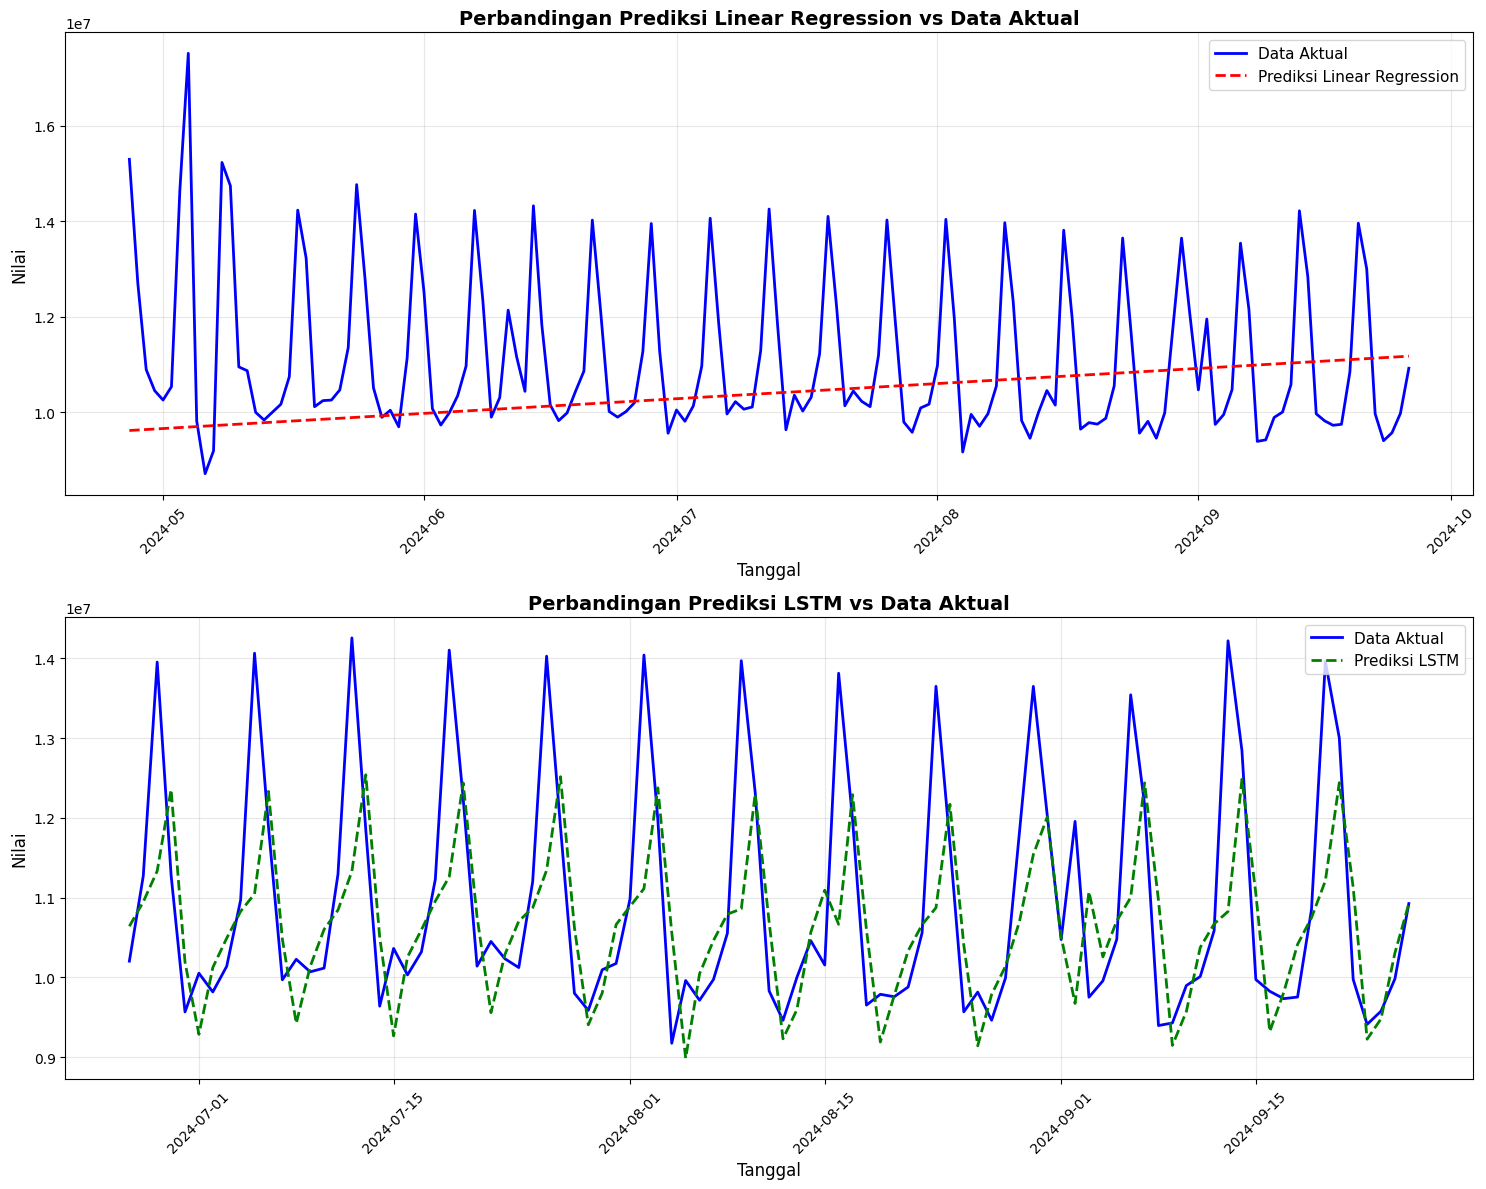

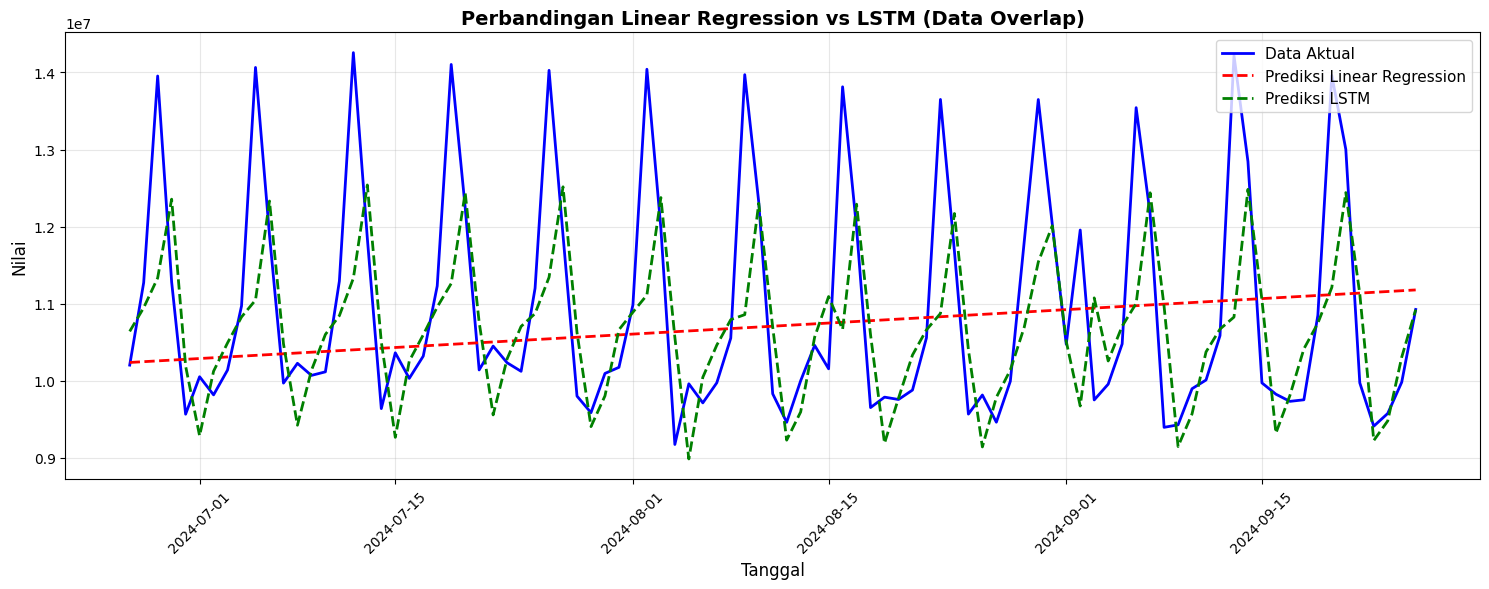

Grafik berhasil dibuat!


In [10]:
import matplotlib.pyplot as plt

# Buat figure dengan subplot
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# ===== GRAFIK 1: LINEAR REGRESSION =====
ax1 = axes[0]
# Ambil index untuk plotting (tanggal dari test set)
test_dates = test.index[:len(y_true_lr)]
ax1.plot(test_dates, y_true_lr, label='Data Aktual', linewidth=2, color='blue')
ax1.plot(test_dates, y_lr, label='Prediksi Linear Regression', linewidth=2, color='red', linestyle='--')
ax1.set_title('Perbandingan Prediksi Linear Regression vs Data Aktual', fontsize=14, fontweight='bold')
ax1.set_xlabel('Tanggal', fontsize=12)
ax1.set_ylabel('Nilai', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# ===== GRAFIK 2: LSTM =====
ax2 = axes[1]
# Untuk LSTM, kita perlu index yang sesuai (mulai dari train_size + window)
# Karena X dimulai dari index window, X_test dimulai dari train_size dalam array X
# yang berarti index train_size + window dalam data asli
window = 60
lstm_start_idx = train_size + window
lstm_dates = df.index[lstm_start_idx:lstm_start_idx + len(y_true_lstm)]
ax2.plot(lstm_dates, y_true_lstm, label='Data Aktual', linewidth=2, color='blue')
ax2.plot(lstm_dates, lstm_pred, label='Prediksi LSTM', linewidth=2, color='green', linestyle='--')
ax2.set_title('Perbandingan Prediksi LSTM vs Data Aktual', fontsize=14, fontweight='bold')
ax2.set_xlabel('Tanggal', fontsize=12)
ax2.set_ylabel('Nilai', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ===== GRAFIK 3: PERBANDINGAN KEDUA MODEL =====
# Buat grafik perbandingan untuk periode yang overlap
fig2, ax3 = plt.subplots(1, 1, figsize=(15, 6))

# Hitung index untuk data overlap
# LSTM mulai dari train_size + window dalam data asli
# Test set mulai dari train_size dalam data asli
# Jadi overlap dimulai dari window dalam test set
overlap_start_in_test = window
overlap_len = min(len(y_true_lstm), len(test) - overlap_start_in_test)

if overlap_len > 0:
    overlap_dates = test.index[overlap_start_in_test:overlap_start_in_test + overlap_len]
    overlap_actual = test[target_col].values[overlap_start_in_test:overlap_start_in_test + overlap_len]
    overlap_lr = test['lr_pred'].values[overlap_start_in_test:overlap_start_in_test + overlap_len]
    overlap_lstm = lstm_pred[:overlap_len]
    
    ax3.plot(overlap_dates, overlap_actual, label='Data Aktual', linewidth=2, color='blue')
    ax3.plot(overlap_dates, overlap_lr, label='Prediksi Linear Regression', linewidth=2, color='red', linestyle='--')
    ax3.plot(overlap_dates, overlap_lstm, label='Prediksi LSTM', linewidth=2, color='green', linestyle='--')
    ax3.set_title('Perbandingan Linear Regression vs LSTM (Data Overlap)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Tanggal', fontsize=12)
    ax3.set_ylabel('Nilai', fontsize=12)
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada data overlap untuk perbandingan")

print("Grafik berhasil dibuat!")

In [11]:
future_lr = []
last_t = test['t'].iloc[-1]

for i in range(1, 31):
    future_lr.append(lr.predict([[last_t + i]])[0])

last_seq = scaled[-window:]
future_lstm = []
cur_seq = last_seq.copy()

for _ in range(30):
    pred = model.predict(cur_seq.reshape(1, window, 1))
    future_lstm.append(pred[0][0])
    cur_seq = np.append(cur_seq[1:], pred)

future_lstm = scaler.inverse_transform(np.array(future_lstm).reshape(-1,1))

pd.DataFrame({
    'day': pd.date_range(df.index[-1] + dt.timedelta(days=1), periods=30),
    'lr_forecast': future_lr,
    'lstm_forecast': future_lstm.flatten()
}).to_csv('forecast_30days.csv', index=False)

print("\n30 hari hasil forecast disimpan → forecast_30days.csv")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2691

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/

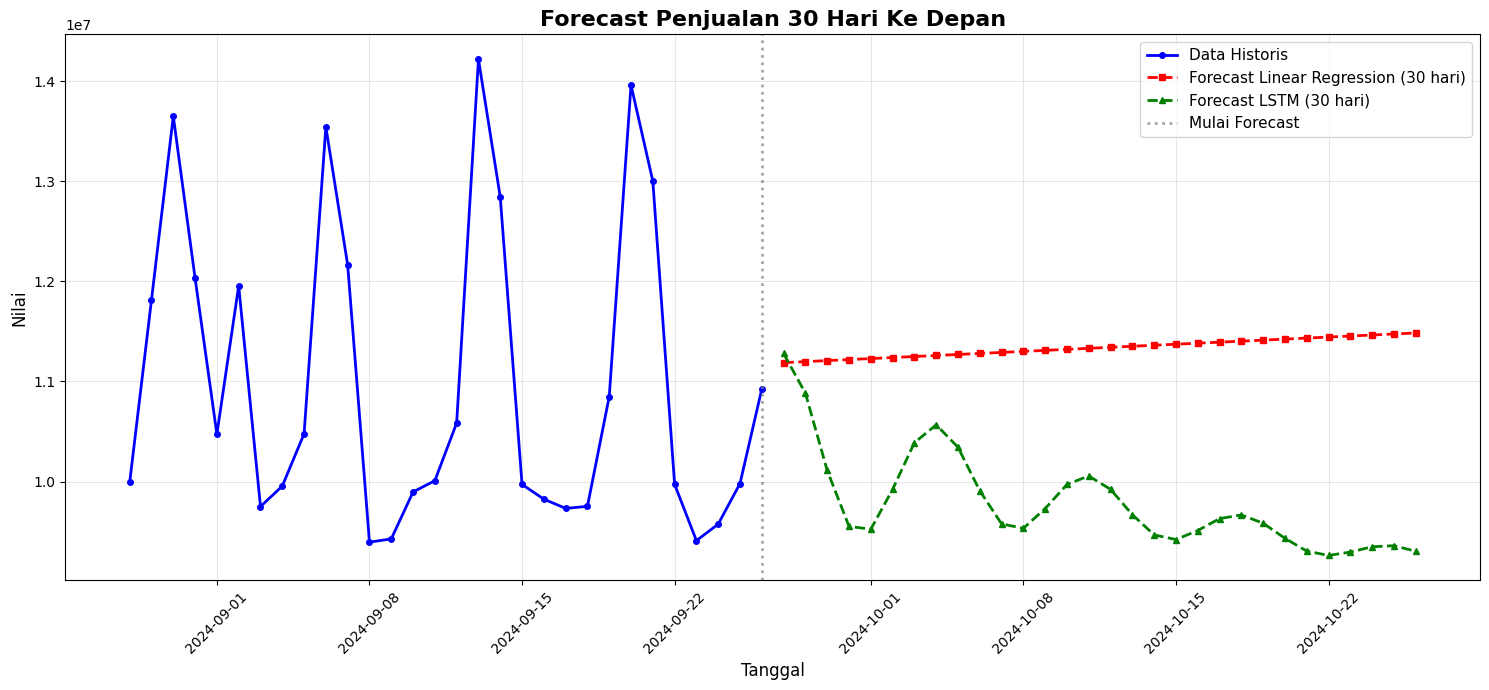


=== FORECAST 30 HARI KE DEPAN ===
       day  lr_forecast  lstm_forecast
2024-09-27 1.118820e+07     11279716.0
2024-09-28 1.119843e+07     10882988.0
2024-09-29 1.120866e+07     10112164.0
2024-09-30 1.121889e+07      9553692.0
2024-10-01 1.122912e+07      9523610.0
2024-10-02 1.123935e+07      9921453.0
2024-10-03 1.124958e+07     10388329.0
2024-10-04 1.125981e+07     10567107.0
2024-10-05 1.127004e+07     10343304.0
2024-10-06 1.128027e+07      9908882.0
2024-10-07 1.129049e+07      9577688.0
2024-10-08 1.130072e+07      9533234.0
2024-10-09 1.131095e+07      9730500.0
2024-10-10 1.132118e+07      9971124.0
2024-10-11 1.133141e+07     10056402.0
2024-10-12 1.134164e+07      9922401.0
2024-10-13 1.135187e+07      9669786.0
2024-10-14 1.136210e+07      9467600.0
2024-10-15 1.137233e+07      9420985.0
2024-10-16 1.138255e+07      9511018.0
2024-10-17 1.139278e+07      9629962.0
2024-10-18 1.140301e+07      9667039.0
2024-10-19 1.141324e+07      9584339.0
2024-10-20 1.142347e+07      

In [12]:
# Visualisasi Forecast 30 Hari Ke Depan
import matplotlib.pyplot as plt

# Baca data forecast yang sudah disimpan
forecast_df = pd.read_csv('forecast_30days.csv')
forecast_df['day'] = pd.to_datetime(forecast_df['day'])

# Tentukan kolom target untuk historis (gunakan yang sama dengan LSTM)
target_col_hist = 'sum_total'
if target_col_hist not in df.columns:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    target_col_hist = numeric_cols[0] if numeric_cols else df.columns[0]

# Ambil data historis terakhir untuk konteks (30 hari terakhir sebelum forecast)
historical_days = 30
historical_end = df.index[-1]
historical_start = df.index[-historical_days] if len(df) >= historical_days else df.index[0]
historical_data = df.loc[historical_start:historical_end, target_col_hist]

# Buat grafik
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

# Plot data historis
ax.plot(historical_data.index, historical_data.values, 
        label='Data Historis', linewidth=2, color='blue', marker='o', markersize=4)

# Plot forecast Linear Regression
ax.plot(forecast_df['day'], forecast_df['lr_forecast'], 
        label='Forecast Linear Regression (30 hari)', linewidth=2, color='red', 
        linestyle='--', marker='s', markersize=4)

# Plot forecast LSTM
ax.plot(forecast_df['day'], forecast_df['lstm_forecast'], 
        label='Forecast LSTM (30 hari)', linewidth=2, color='green', 
        linestyle='--', marker='^', markersize=4)

# Garis vertikal untuk memisahkan historis dan forecast
ax.axvline(x=historical_end, color='gray', linestyle=':', linewidth=2, alpha=0.7, label='Mulai Forecast')

ax.set_title('Forecast Penjualan 30 Hari Ke Depan', fontsize=16, fontweight='bold')
ax.set_xlabel('Tanggal', fontsize=12)
ax.set_ylabel('Nilai', fontsize=12)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Tampilkan tabel forecast
print("\n=== FORECAST 30 HARI KE DEPAN ===")
print(forecast_df.to_string(index=False))
print(f"\nRata-rata Forecast LR: {forecast_df['lr_forecast'].mean():.2f}")
print(f"Rata-rata Forecast LSTM: {forecast_df['lstm_forecast'].mean():.2f}")
print(f"Selisih Rata-rata: {abs(forecast_df['lr_forecast'].mean() - forecast_df['lstm_forecast'].mean()):.2f}")

Target kolom: sum_total
LR samples: 153 | LSTM samples: 93


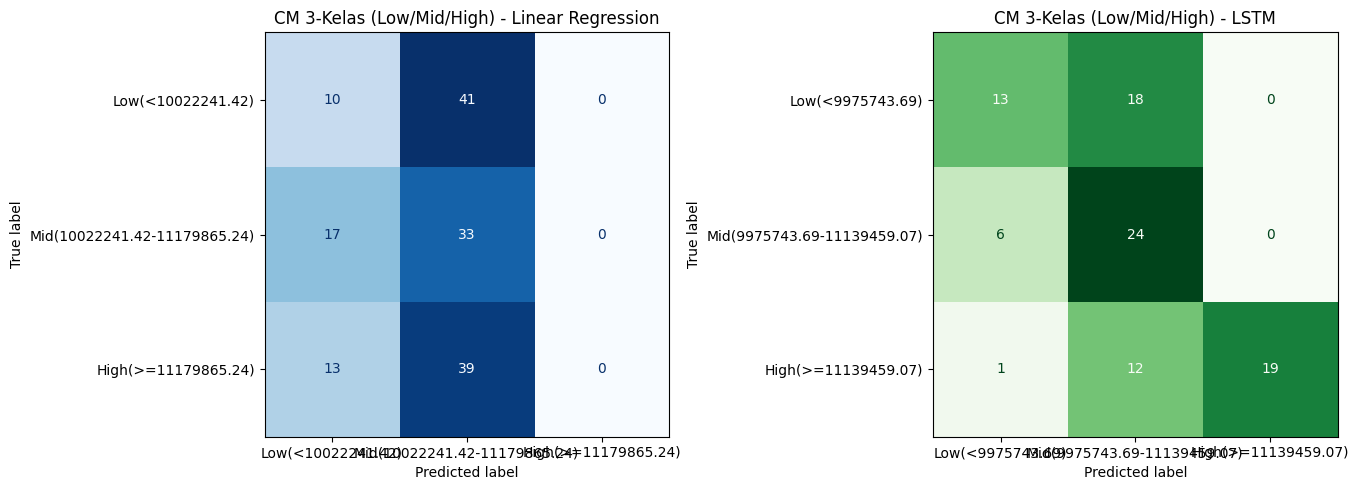

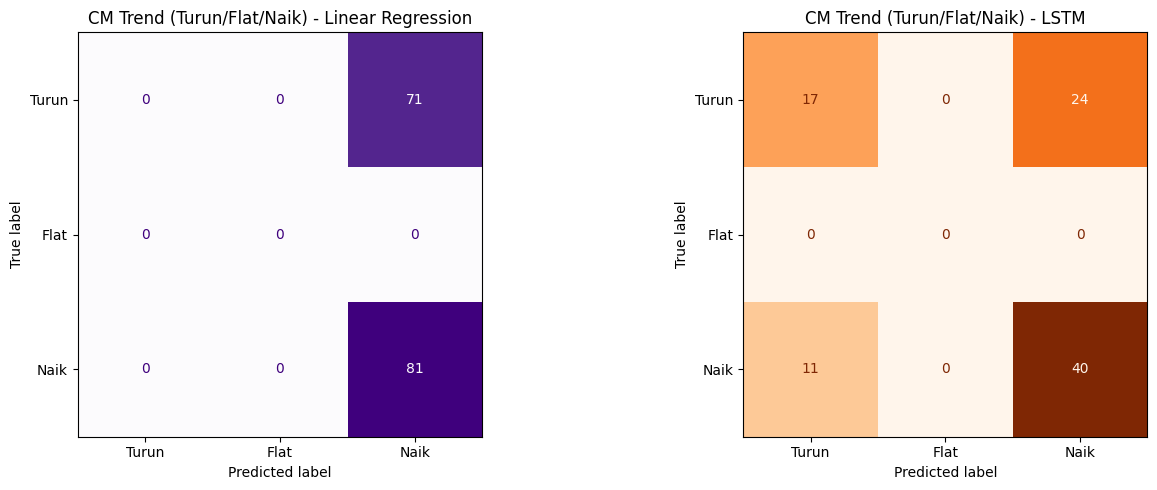

In [14]:
# Confusion Matrix untuk Forecasting (Regresi) dengan Diskretisasi
# Catatan: confusion matrix itu metrik KLASIFIKASI.
# Untuk forecasting/regresi, kita ubah nilai kontinu menjadi kelas:
# (1) 3 kelas: Low/Mid/High (berdasarkan quantile)
# (2) Trend: Turun/Flat/Naik (berdasarkan perubahan harian)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ====== Helper: ubah nilai kontinu -> kelas rendah/sedang/tinggi berbasis quantile ======
def to_3class_quantile(y, q1=0.33, q2=0.66, ref=None):
    """Return labels 0/1/2 (low/medium/high) dan batas quantile."""
    ref_arr = np.asarray(ref if ref is not None else y).astype(float)
    a, b = np.quantile(ref_arr, [q1, q2])
    y_arr = np.asarray(y).astype(float)
    labels = np.digitize(y_arr, bins=[a, b], right=False)  # 0,1,2
    return labels, (a, b)

# ====== Helper: arah perubahan (naik/turun/flat) ======
def to_trend_3class(y, eps=0.0):
    """Return labels 0/1/2 untuk (turun/flat/naik) berdasarkan delta harian."""
    y = np.asarray(y).astype(float)
    dy = np.diff(y)
    labels = np.zeros_like(dy, dtype=int)  # default turun
    labels[np.abs(dy) <= eps] = 1          # flat
    labels[dy > eps] = 2                   # naik
    return labels

# ====== Pastikan variabel penting tersedia (auto-setup jika kernel baru) ======
if 'df' not in globals():
    raise NameError("Variabel 'df' belum ada. Jalankan dulu cell load & preprocessing (Cell 1-2).")

# Tentukan target kolom yang dipakai
preferred = ['sum_total', 'quantity', 'price_base']
if 'target_col' not in globals() or target_col not in df.columns:
    target_col = next((c for c in preferred if c in df.columns), None)
    if target_col is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        numeric_cols = [c for c in numeric_cols if c != 'Unnamed: 0']
        if not numeric_cols:
            raise ValueError("Tidak ada kolom numerik yang bisa dipakai sebagai target.")
        target_col = numeric_cols[0]

# Split train/test
if 'train_size' not in globals():
    train_size = int(len(df) * 0.8)
if 'train' not in globals() or 'test' not in globals():
    train, test = df[:train_size].copy(), df[train_size:].copy()

# ====== Pastikan prediksi Linear Regression tersedia ======
if 't' not in train.columns:
    train = train.copy()
    test = test.copy()
    train['t'] = np.arange(len(train))
    test['t'] = np.arange(len(train), len(train) + len(test))

if 'lr_pred' not in test.columns:
    lr = LinearRegression()
    lr.fit(train[['t']], train[target_col])
    test['lr_pred'] = lr.predict(test[['t']])

y_true_lr = test[target_col].values
y_lr = test['lr_pred'].values

# ====== Pastikan prediksi LSTM tersedia ======
# Jika y_test/scaler/lstm_pred belum ada, kita training ulang LSTM di sini (supaya cell ini tetap bisa jalan setelah restart kernel)
need_lstm = any(name not in globals() for name in ['y_test', 'scaler', 'lstm_pred'])

if need_lstm:
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[[target_col]])

    window = 60
    X, y = [], []
    for i in range(window, len(scaled)):
        X.append(scaled[i-window:i, 0])
        y.append(scaled[i, 0])

    X, y = np.array(X), np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    model = Sequential([
        LSTM(64, return_sequences=False, input_shape=(window, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mae')
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)  # dibuat lebih cepat

    lstm_pred = model.predict(X_test, verbose=0)
    lstm_pred = scaler.inverse_transform(lstm_pred)
else:
    # pastikan bentuknya 1D
    if np.ndim(lstm_pred) > 1:
        lstm_pred = np.asarray(lstm_pred).reshape(-1)

# y_true_lstm dari y_test (yang masih scaled) -> inverse
if 'y_true_lstm' not in globals():
    y_true_lstm = scaler.inverse_transform(np.asarray(y_test).reshape(-1, 1)).reshape(-1)

# Pastikan lstm_pred 1D
lstm_pred = np.asarray(lstm_pred).reshape(-1)

# Samakan panjang LSTM
min_len = min(len(y_true_lstm), len(lstm_pred))
y_true_lstm = np.asarray(y_true_lstm).reshape(-1)[:min_len]
lstm_pred = lstm_pred[:min_len]

print(f"Target kolom: {target_col}")
print(f"LR samples: {len(y_true_lr)} | LSTM samples: {len(y_true_lstm)}")

# ========== 1) Confusion matrix: Low/Mid/High ==========
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

y_true_lr_cls, (a_lr, b_lr) = to_3class_quantile(y_true_lr)
y_pred_lr_cls, _ = to_3class_quantile(y_lr, ref=y_true_lr)
cm_lr = confusion_matrix(y_true_lr_cls, y_pred_lr_cls, labels=[0, 1, 2])
ConfusionMatrixDisplay(
    cm_lr,
    display_labels=[f"Low(<{a_lr:.2f})", f"Mid({a_lr:.2f}-{b_lr:.2f})", f"High(>={b_lr:.2f})"],
).plot(ax=axes[0], cmap='Blues', colorbar=False, values_format='d')
axes[0].set_title('CM 3-Kelas (Low/Mid/High) - Linear Regression')

y_true_lstm_cls, (a_l, b_l) = to_3class_quantile(y_true_lstm)
y_pred_lstm_cls, _ = to_3class_quantile(lstm_pred, ref=y_true_lstm)
cm_lstm = confusion_matrix(y_true_lstm_cls, y_pred_lstm_cls, labels=[0, 1, 2])
ConfusionMatrixDisplay(
    cm_lstm,
    display_labels=[f"Low(<{a_l:.2f})", f"Mid({a_l:.2f}-{b_l:.2f})", f"High(>={b_l:.2f})"],
).plot(ax=axes[1], cmap='Greens', colorbar=False, values_format='d')
axes[1].set_title('CM 3-Kelas (Low/Mid/High) - LSTM')

plt.tight_layout()
plt.show()

# ========== 2) Confusion matrix: Trend (Turun/Flat/Naik) ==========
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

y_true_lr_tr = to_trend_3class(y_true_lr)
y_pred_lr_tr = to_trend_3class(y_lr)
n = min(len(y_true_lr_tr), len(y_pred_lr_tr))
cm_lr_tr = confusion_matrix(y_true_lr_tr[:n], y_pred_lr_tr[:n], labels=[0, 1, 2])
ConfusionMatrixDisplay(cm_lr_tr, display_labels=['Turun', 'Flat', 'Naik']).plot(
    ax=axes[0], cmap='Purples', colorbar=False, values_format='d'
)
axes[0].set_title('CM Trend (Turun/Flat/Naik) - Linear Regression')

y_true_lstm_tr = to_trend_3class(y_true_lstm)
y_pred_lstm_tr = to_trend_3class(lstm_pred)
n = min(len(y_true_lstm_tr), len(y_pred_lstm_tr))
cm_lstm_tr = confusion_matrix(y_true_lstm_tr[:n], y_pred_lstm_tr[:n], labels=[0, 1, 2])
ConfusionMatrixDisplay(cm_lstm_tr, display_labels=['Turun', 'Flat', 'Naik']).plot(
    ax=axes[1], cmap='Oranges', colorbar=False, values_format='d'
)
axes[1].set_title('CM Trend (Turun/Flat/Naik) - LSTM')

plt.tight_layout()
plt.show()
